In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyper Parameter Configuration
EPOCHS = 5
BATCH_SIZE = 32

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    # shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [12]:
# print(ds_info)
image_shape = ds_info.features['image'].shape
image_dtype = ds_info.features['image'].dtype

print(f'image shape: {image_shape}')
print(f'image dtype: {image_dtype}')

image shape: (300, 300, 3)
image dtype: <dtype: 'uint8'>


In [13]:
# print(ds_train)
num_train = ds_info.splits['train'].num_examples
print(f'num of train: {num_train}')

# print(ds_test)
num_test = ds_info.splits['test'].num_examples
print(f'num of test : {num_test}')

num of train: 2520
num of test : 372


In [14]:
CLASS_NUM = ds_info.features['label'].num_classes # = 3
CLASS_NAMES = ['rock', 'paper', 'scissors']

print(f'num of class: {CLASS_NUM}\n')

for i in range(CLASS_NUM):
    print(i, CLASS_NAMES[i])

num of class: 3

0 rock
1 paper
2 scissors


scissors


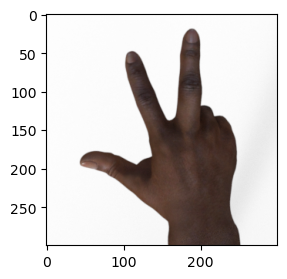

In [15]:
plt.figure(figsize=(3, 3))

for image, label in ds_train.take(1):
    plt.imshow(image)
    print(CLASS_NAMES[label.numpy()])

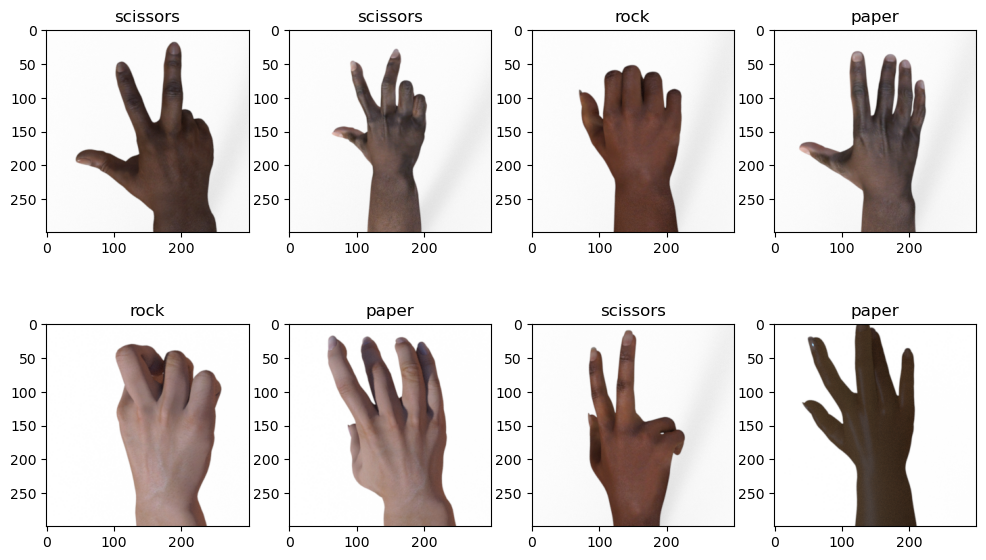

In [16]:
plt.figure(figsize=(12, 7))

i = 1
for image, label in ds_train.take(8):
    plt.subplot(2, 4, i)
    i += 1
    # plt.axis('Off')
    label = CLASS_NAMES[label.numpy()]
    plt.title(f'{label}')
    plt.imshow(image)

In [17]:
# 이후에 batch size 설정 이후 데이터를 하나씩 꺼낼 수 없기 때문에,
# 미리 test set의 첫 번째 데이터를 꺼내어 변수에 저장

for image, label in ds_test.take(1):
    test_image0 = image.numpy()
    test_label0 = label.numpy()

In [18]:
INPUT_IMG_SIZE = 100

def normalize_img(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [19]:
ds_train = ds_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(num_train)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

In [21]:
keras.utils.plot_model(model, show_shapes=True, dpi = 70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(ds_train, epochs=EPOCHS, validation_data = ds_test)

Epoch 1/5
79/79 [==============================] - 25s 269ms/step - loss: 1.1007 - accuracy: 0.3298 - val_loss: 1.0950 - val_accuracy: 0.3333
Epoch 2/5
79/79 [==============================] - 22s 280ms/step - loss: 1.0941 - accuracy: 0.3667 - val_loss: 1.0916 - val_accuracy: 0.3360
Epoch 3/5
79/79 [==============================] - 25s 322ms/step - loss: 1.0880 - accuracy: 0.3861 - val_loss: 1.0869 - val_accuracy: 0.4489
Epoch 4/5
79/79 [==============================] - 21s 269ms/step - loss: 1.0805 - accuracy: 0.4230 - val_loss: 1.0815 - val_accuracy: 0.5269
Epoch 5/5
79/79 [==============================] - 20s 257ms/step - loss: 1.0666 - accuracy: 0.4556 - val_loss: 1.0660 - val_accuracy: 0.4919


In [24]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)

print(f'\n테스트 정확도: {test_acc*100:.2f}%')

12/12 - 1s - loss: 1.0660 - accuracy: 0.4919 - 716ms/epoch - 60ms/step

테스트 정확도: 49.19%


In [25]:
predictions = model.predict(ds_test)

print(predictions)
print(len(predictions))

12/12 [==============================] - 1s 57ms/step
[[0.32205543 0.32303405 0.35491052]
 [0.27138647 0.3909521  0.33766136]
 [0.3182697  0.3344996  0.3472307 ]
 ...
 [0.3410944  0.3262202  0.3326854 ]
 [0.30327725 0.34922546 0.3474973 ]
 [0.31343699 0.3407546  0.34580848]]
372


In [26]:
print(predictions[0])

[0.32205543 0.32303405 0.35491052]


In [27]:
CLASS_NAMES[np.argmax(predictions[0])]

'scissors'

scissors


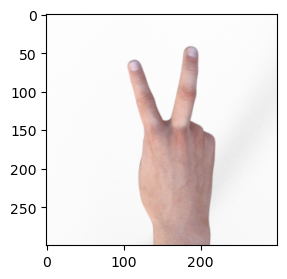

In [28]:
plt.figure(figsize=(3, 3))

plt.imshow(test_image0)
print(CLASS_NAMES[test_label0])

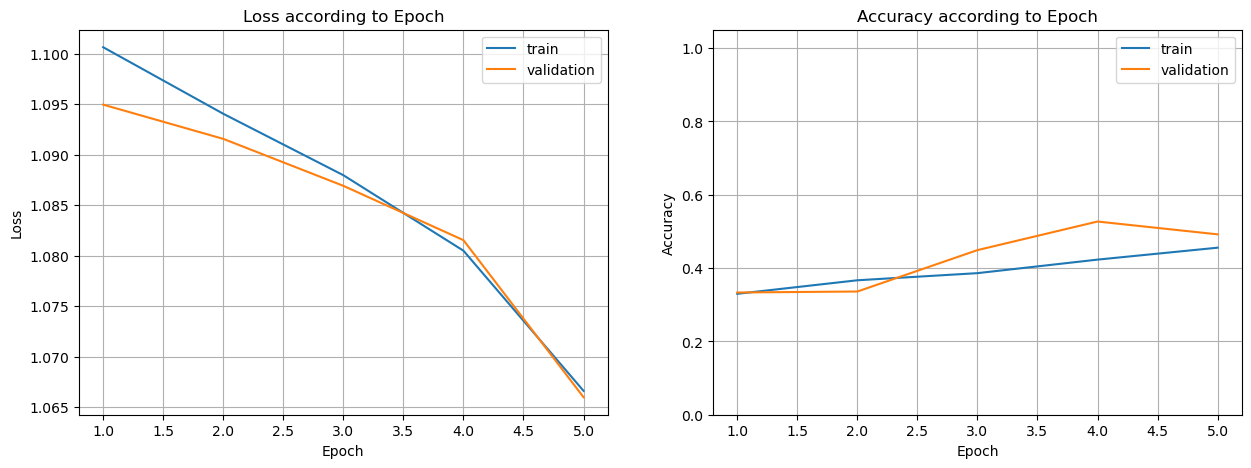

In [29]:
import pandas as pd

df_hist = pd.DataFrame(history.history)
df_hist['epoch'] = range(1, EPOCHS+1)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title('Loss according to Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df_hist['epoch'], df_hist['loss'], label='train')
plt.plot(df_hist['epoch'], df_hist['val_loss'], label = 'validation')
# plt.ylim([0, 1.5])
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy according to Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(df_hist['epoch'], df_hist['accuracy'], label='train')
plt.plot(df_hist['epoch'], df_hist['val_accuracy'], label='validation')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.show()